## TASK 1: DATA PREPARATION (30 POINTS)
The first phase of a Data Mining project typically includes getting familiar with the domain and pre-processing the dataset in a suitable manner. In this part of the assignment, we will go through those steps.

### TASK 1A: EXPLORATORY DATA ANALYSIS (10 POINTS)
Start with exploring the raw data that is available: \
• Notice all sorts of properties of the dataset: how many records are there, how many
attributes, what kinds of attributes are there, ranges of values, distribution of values,
relationships between attributes, missing values, and so on. A table is often a suitable
way of showing such properties of a dataset. Notice if something is interesting (to you,
or in general), make sure you write it down if you find something worth mentioning. \
• Make various plots of the data. Is there something interesting worth reporting? Report the figures, discuss what is in them. What meaning do those bars, lines, dots, etc.
convey? Please select essential and interesting plots for discussion, as you have limited
space for reporting your findings.

In [1]:
# Import libraries
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# Import as Dataframe
df = pd.read_csv('./Data/dataset_mood_smartphone.csv')
df.head()

# Drop unnecessary columns
data =  df.drop(['Unnamed: 0'], axis=1)
    
# Make sure the 'time' column is of type datetime
data['time'] = pd.to_datetime(data['time'])

In [14]:
# Inspect the dataset
print(f"Number of records: {len(data)}")
print(f"Number of attributes: {len(data.columns)}")
print(f"Attribute types:\n{data.dtypes}")
print(f"Ranges of values:\n{data['value'].describe()}")

Number of records: 376912
Number of attributes: 4
Attribute types:
id                  object
time        datetime64[ns]
variable            object
value              float64
dtype: object
Ranges of values:
count    376710.000000
mean         40.665313
std         273.726007
min      -82798.871000
25%           2.025000
50%           7.029000
75%          29.356000
max       33960.246000
Name: value, dtype: float64


In [15]:
# Check for missing values
print(f"Number of missing values:\n{data.isnull().sum()}") # 202 missing values in the 'value' column

# Generate descriptive statistics for the dataset
print(data.describe())

# Counts of values recorded per month
pd.to_datetime(data["time"]).dt.to_period('M').value_counts().sort_index()

Number of missing values:
id            0
time          0
variable      0
value       202
dtype: int64
                                time          value
count                         376912  376710.000000
mean   2014-04-16 05:01:16.959544064      40.665313
min       2014-02-17 07:00:52.197000  -82798.871000
25%              2014-04-03 15:00:00       2.025000
50%    2014-04-15 22:13:12.874500096       7.029000
75%    2014-04-27 19:25:38.207000064      29.356000
max              2014-06-09 00:00:00   33960.246000
std                              NaN     273.726007


time
2014-02      1102
2014-03     73620
2014-04    233483
2014-05     66808
2014-06      1899
Freq: M, Name: count, dtype: int64

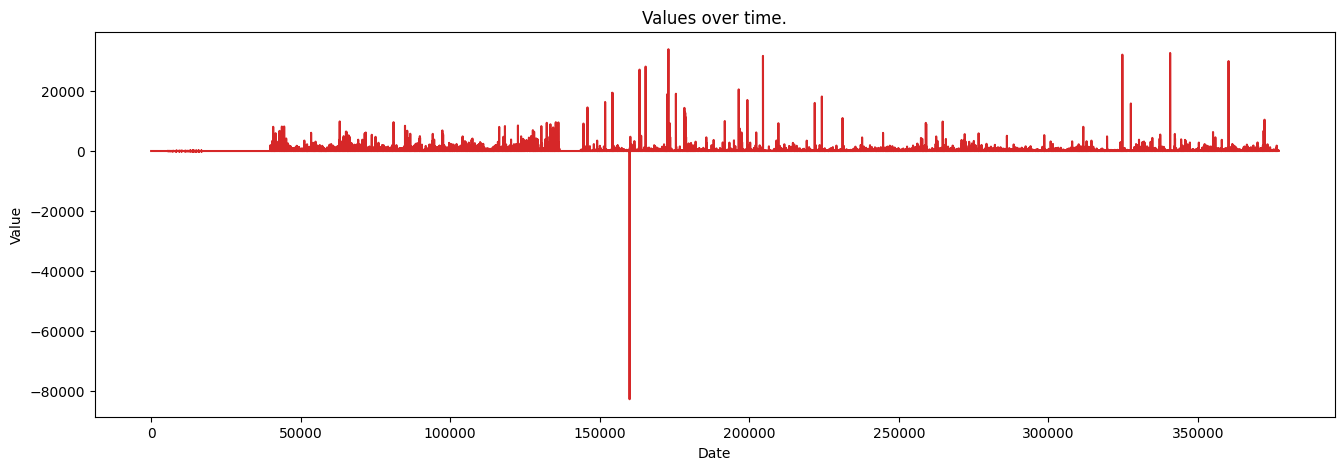

In [16]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, x = data.index, y = data.value, title='Values over time.')    


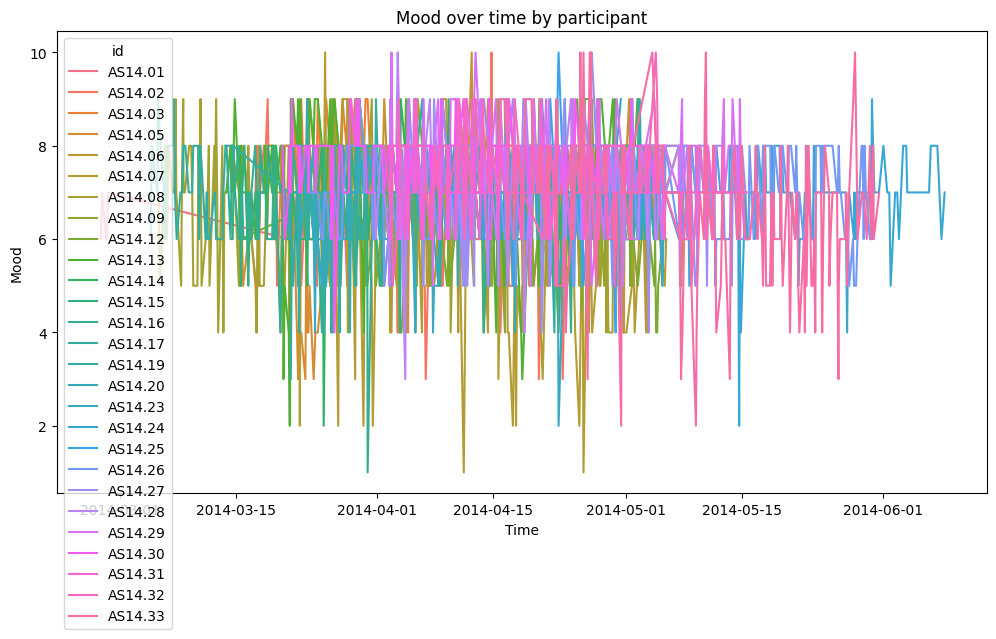

In [17]:
# Create line plot of mood variable over time for each participant
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='value', data=data[data['variable'] == 'mood'], hue='id')
plt.title('Mood over time by participant')
plt.xlabel('Time')
plt.ylabel('Mood')
plt.show()

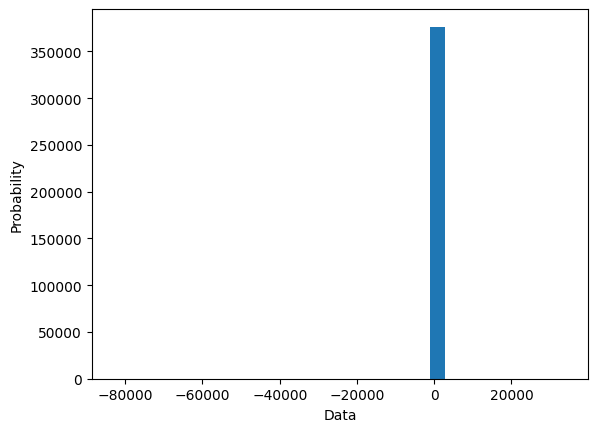

In [18]:
# Data not normally distributed, a lot of extreme values
# Show histograms - all variables except for the identifier variables
plt.hist(np.array(data['value'].tolist()).astype('float'), density=False, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()


### TASK 1B: DATA CLEANING (10 POINTS)
As the insights from Task 1A will have shown, the dataset you analyze contains quite some
noise. Values are sometimes missing, and extreme or incorrect values are seen that are likely
outliers you may want to remove from the dataset. We will clean the dataset in two steps: \
• Apply an approach to remove extreme and incorrect values from your dataset. Describe
what your approach is, why you consider that to be a good approach, and describe what
the result of applying the approach is. \
• Impute the missing values using two different approaches. Describe the approaches
and study the impact of applying them to your data. Argue which one of the two approaches would be most suitable and select that one to form your cleaned dataset. Also
base yourself on scientific literature for making your choice.
Advanced: The advanced dataset contains a number of time series, select approaches to impute missing values that are logical for such time series. Also consider what to do with prolonged periods of missing data in a time series.

In [3]:
from Preprocessing.datacleaning import remove_incorrect_values, aggregate_and_standardize, run_isolation_forest

In [4]:
# Remove incorrect values
valid_df, removed_df = remove_incorrect_values(data)

/Users/gast/Desktop/datamijnen/Preprocessing/datacleaning.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['date'] = input_data['time'].dt.date
/Users/gast/Desktop/datamijnen/Preprocessing/datacleaning.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['time'] = input_data['time'].dt.time


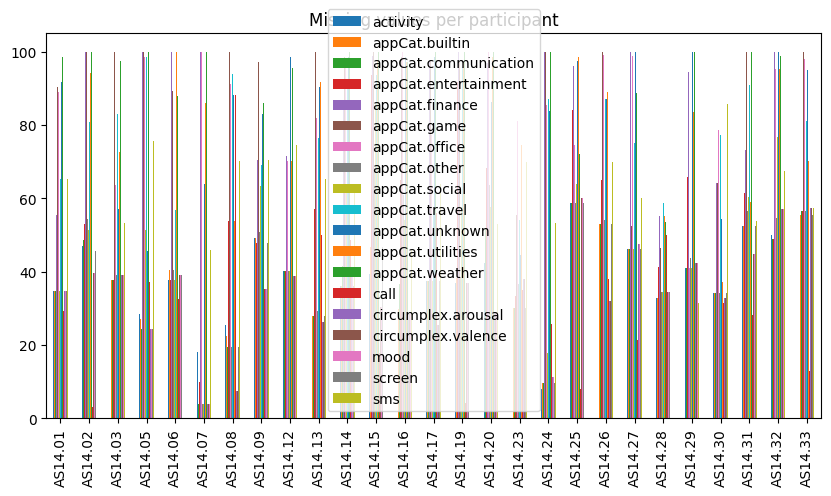

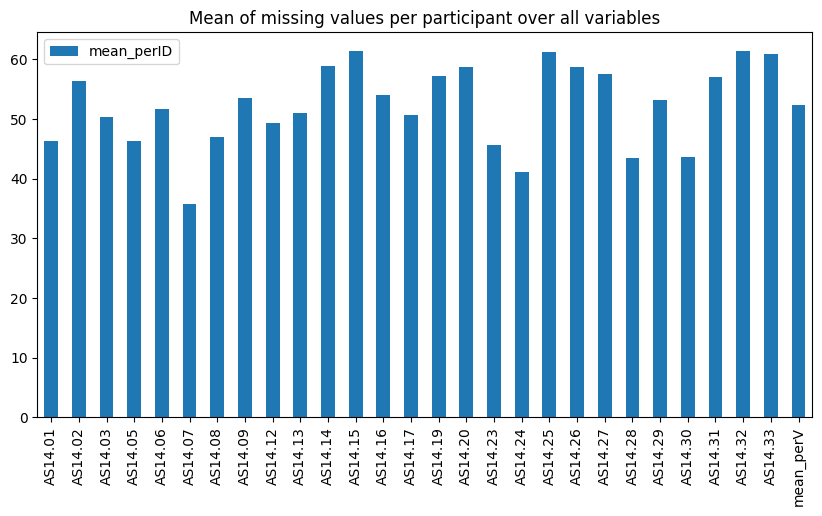

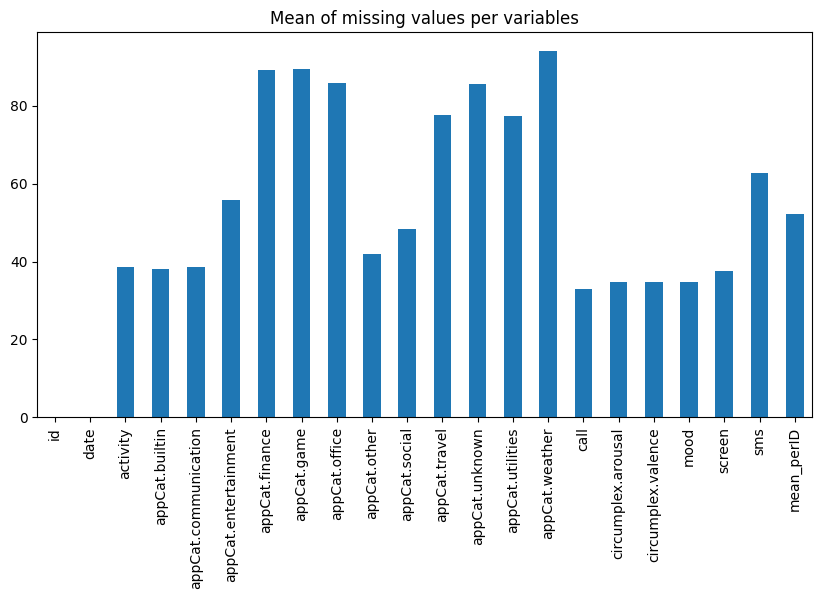

In [5]:
# Call the function and store the result in a new dataframe
new_df = aggregate_and_standardize(valid_df)

# Check the percentage of missing values in the new dataframe for each column
new_df.isnull().sum() / len(new_df) * 100

# Drop columns that contain more than 50% missing values
new_df['date'].min()
new_df['date'].max()

new_df['date'].nunique() # 113 unique days
new_df.groupby(['id', 'date']).count()

# Count the number of data points for each day per participant
new_df.groupby(['id', 'date']).count().groupby('id').count().reset_index()

# Calculate the percentage of missing values for each row
new_df['missing_percentage'] = new_df.isnull().sum(axis=1) / len(new_df.columns) * 100

# Sort id's with the highest percentage of missing values
new_df.sort_values('missing_percentage', ascending=False)

# Calculate the percentage of missing values for each participant
new_df[['id', 'missing_percentage']].groupby('id').mean().reset_index().sort_values('missing_percentage', ascending=False)


# Calculate the percentage of complete data for each participant per day
data_counts = new_df.groupby(['id', 'date']).count().reset_index()

# Count the number of days that follow each other of the 'date' column for each participant
data_counts.groupby('id').apply(lambda x: x['date'].diff().dt.days == 1).groupby('id').sum().reset_index()

# Count the size of date gaps for each participant
data_counts.groupby('id').apply(lambda x: x['date'].diff().dt.days).groupby('id').max().reset_index()

# Fill a dataframe with a for loop with the number of missing values for each column for each participant where the rows are the variables and the columns are the participants id's
missing_values = pd.DataFrame(columns=new_df['id'].unique(), index=new_df.columns[:-1])

for id in new_df['id'].unique():
    missing_values[id] = new_df[new_df['id'] == id].isnull().sum()/len(new_df[new_df['id'] == id]) * 100
    
# Plot the missing values for each participant
missing_values.iloc[2:,].T.plot(kind='bar', figsize=(10,5), title='Missing values per participant')
plt.show()

# Add the mean of the missing values per column and per row to the dataframe
missing_values.loc['mean_perID'] = missing_values.mean()
missing_values['mean_perV'] = missing_values.mean(axis=1)

# Plot the mean of the missing values perID
missing_values.iloc[-1:,].T.plot(kind='bar', figsize=(10,5), title='Mean of missing values per participant over all variables')
plt.show()     

# Plot the mean of the missing values perV
missing_values.iloc[:,-1].T.plot(kind='bar', figsize=(10,5), title='Mean of missing values per variables')
plt.show() 

# Calculate the number of participants up to 42 days in study, n (%)
    

In [ ]:
# EMA study adherence

# Number of days in study, mean (SD) 35.5 (3.8)

# Last day rated, mean (SD) 40.3 (3.3)

# Up to 42 days in study, n (%) 18 (67)



# Responses per day (n), n (%)

# 1 9 (1)

# 2 25 (3)

# 3 44 (5)

# 4 228 (24)

# 5 653 (68)



# EMA mood measures, b mean (SD)

# One-dimensional mood 7.0 (0.95)

# Circumplex: valence 0.7 (0.63)

# Circumplex: arousal –0.1 (1.00)

In [ ]:
# Loop through the columns and run the isolation forest algorithm
for column in new_df.columns[2:]:
    new_df = run_isolation_forest(new_df, column)

In [25]:
# Run the isolation forest algorithm to identify outliers
merged_df = run_isolation_forest(data)

/Users/gast/Desktop/datamijnen/venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


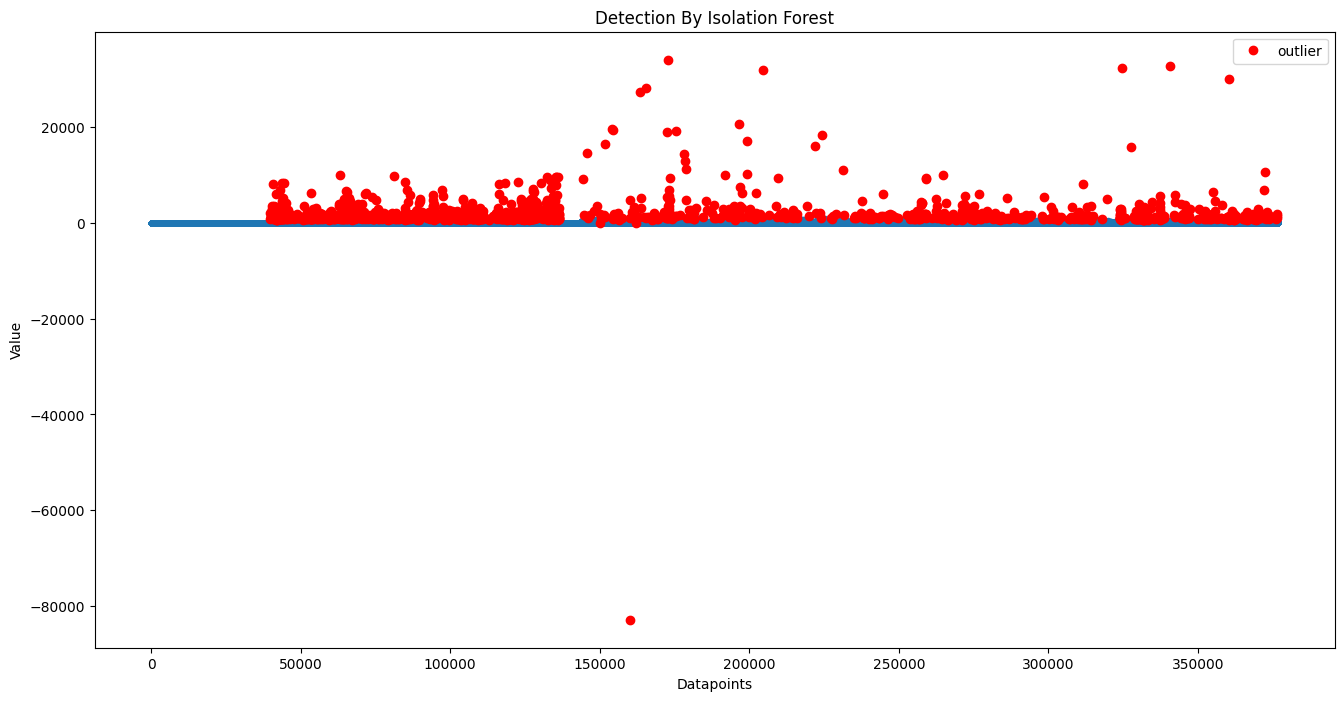

In [26]:
# Plot the results of the isolation forest algorithm
cleaned_data = merged_df.loc[merged_df['anomaly'] == 0]
outliers = merged_df.loc[merged_df['anomaly'] == 1]
outlier_index = list(merged_df.index)

#datapoints classified -1 are anomalous
merged_df['anomaly'].value_counts() # 1884 outliers

# PLot outliers
plt.figure(figsize = (16, 8))
plt.plot(cleaned_data['value'], marker = '.')
plt.plot(outliers['value'], 'o', color = 'red', label = 'outlier')
plt.title('Detection By Isolation Forest')

#plt.grid()
plt.ylabel('Value')
plt.xlabel('Datapoints')
plt.legend()
plt.show()

(1694, 4)


/Users/gast/Desktop/datamijnen/venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


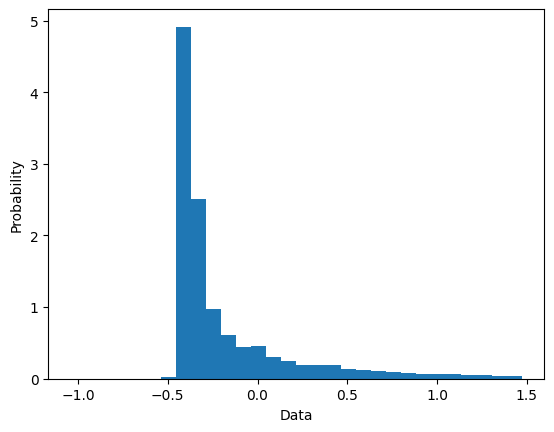

In [19]:
# Outlier removal based on Z-score solely (NOT GOOD BECAUSE NOT NORMALLY DISTRIBUTED)
# Print the upper and lower limits
print_z_score_limits(data, "value")
'Variable Name: value | Upper limit: 861.84 | Lower limit: -780.51'

# Filter outliers
sample_z = data[(data['value'] >= 861.84) | (data['value'] <= -780.51)]
print(sample_z.shape) # (1694, 4) --> 1694 outliers according to Z-score

# Outlier removal based on IQR
c_data = remove_outliers(data)

# Density plot of the cleaned data after outlier removal
plt.hist(np.array(c_data['value'].tolist()).astype('float'), density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

### TASK 1C: FEATURE ENGINEERING (10 POINTS)
While we now have a clean dataset, we can still take one step before we move to classification
that can in the end help to improve performance, namely feature engineering. As discussed
during the lectures, feature engineering is a creative process and can involve for example the
transformation of values (e.g. take the log of values given a certain distribution of values) or combining multiple features (e.g. two features that are more valuable combined than the two
separate values). Think of a creative feature engineering approach for your dataset, describe
it, and apply it. Report on why you think this is a useful enrichment of your dataset.
Advanced: Essentially there are two approaches you can consider to create a predictive model
using this dataset (which we will do in the next part of this assignment): (1) use a machine
learning approach that can deal with temporal data (e.g. ARIMA, recurrent neural networks)
or you can try to aggregate the history somehow to create attributes that can be used in a
more common machine learning approach (e.g. SVM, decision tree). For instance, you use
the average mood during the last five days as a predictor. Ample literature is present in the
area of temporal data mining that describes how such a transformation can be made. For
the feature engineering, you are going to focus on such a transformation in this part of the
assignment. This is illustrated in Figure 1.

In the end, we end up with a dataset with a number of training instances per patient (as
you have a number of time points for which you can train), i.e. an instance that concerns
the mood at t=1, t=2, etc. Of course it depends on your choice of the history you consider
relevant from what time point you can start predicting (if you use a windows of 5 days of
history to create attributes you cannot create training instances before the 6th day). To come
to this dataset, you need to:

1. Define attributes that aggregate the history, draw inspiration from the field of temporal
data mining.
2. Define the target by averaging the mood over the entire day.
3. Create an instance-based dataset as described in Figure 1.

In [27]:
# Import the libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

# Import as Dataframe
df = pd.read_csv('./Data/dataset_mood_smartphone.csv')
df.head()

# Drop unnecessary columns
data =  df.drop(['Unnamed: 0'], axis=1)
    
# Make sure the 'time' column is of type datetime
data['time'] = pd.to_datetime(data['time'])


# Deleting incorrect values from the dataset 

# Put the above code inside a function 
def remove_incorrect_values(input_data):
    
    # Set the valid ranges for each variable
    valid_ranges = {'mood': (1, 10),
                    'circumplex.arousal': (-2, 2),
                    'circumplex.valence': (-2, 2),
                    'activity': (0, 1),
                    'screen': (0, 1000000000),
                    'call': (0, 1),
                    'sms': (0, 1),
                    'appCat.builtin': (0, 1000000000),
                    'appCat.communication': (0, 100000000),
                    'appCat.entertainment': (0, 1000000000),
                    'appCat.finance': (0, 1000000000),
                    'appCat.game': (0, 1000000000),
                    'appCat.office': (0, 1000000000),
                    'appCat.other': (0, 1000000000),
                    'appCat.social': (0, 1000000000),
                    'appCat.travel': (0, 1000000000),
                    'appCat.unknown': (0, 1000000000),
                    'appCat.utilities': (0, 1000000000),
                    'appCat.weather': (0, 1000000000)}
    
    # Filter the dataframe to remove rows with values outside the valid ranges, however, keep the NaN values
    valid_df = data[data.apply(lambda x: valid_ranges[x.variable][0] <= x.value <= valid_ranges[x.variable][1] if not pd.isnull(x.value) else True, axis=1)]
    
    # Create a separate dataframe for the removed rows
    removed_df = input_data[~input_data.index.isin(valid_df.index)]
    
    # Return the valid and removed dataframes
    return valid_df, removed_df

valid_df, removed_df = remove_incorrect_values(data)


# Split the time into date and time
valid_df['date'] = valid_df['time'].dt.date
valid_df['time'] = valid_df['time'].dt.time

# Create a new long format dataframe where each row is a unique combination of id and date and the variables are the mean of the values for that day 
new_df = valid_df.pivot_table(index=['id', 'date'], 
                          columns='variable', 
                          values='value', 
                          aggfunc='mean').reset_index()

# Check the percentage of missing values in the new dataframe for each column
new_df.isnull().sum() / len(new_df) * 100

# Drop columns that contain more than 50% missing values





/var/folders/rh/lk15sxf50jzg85yx76069l_00000gn/T/ipykernel_56350/3112437568.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['date'] = valid_df['time'].dt.date
/var/folders/rh/lk15sxf50jzg85yx76069l_00000gn/T/ipykernel_56350/3112437568.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['time'] = valid_df['time'].dt.time


variable
id                       0.000000
date                     0.000000
activity                39.787126
appCat.builtin          39.432337
appCat.communication    40.040547
appCat.entertainment    56.918398
appCat.finance          89.508363
appCat.game             90.217942
appCat.office           86.011151
appCat.other            43.233654
appCat.social           49.923974
appCat.travel           78.256462
appCat.unknown          86.619361
appCat.utilities        78.053725
appCat.weather          94.272681
call                    32.184491
circumplex.arousal      35.732387
circumplex.valence      35.833756
mood                    35.732387
screen                  38.824126
sms                     62.797770
dtype: float64

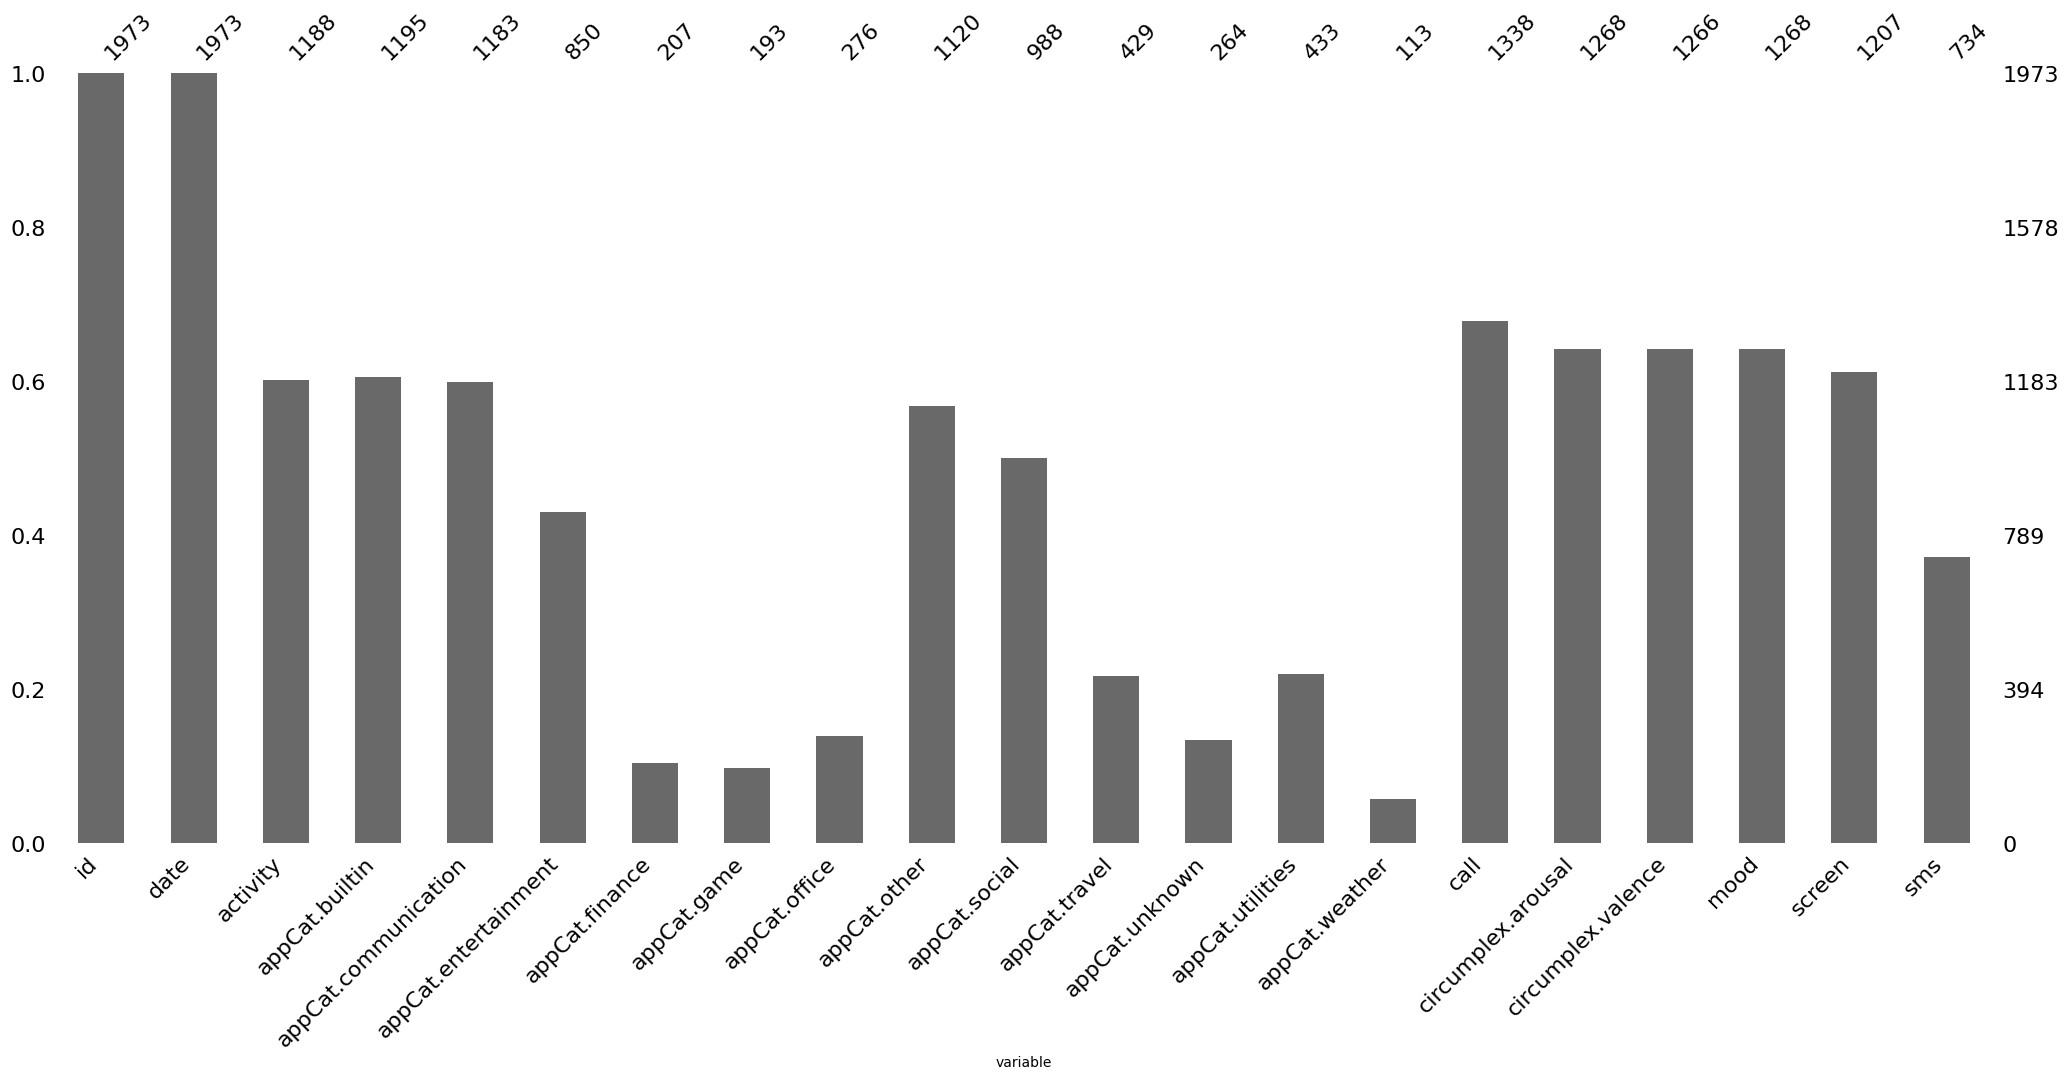

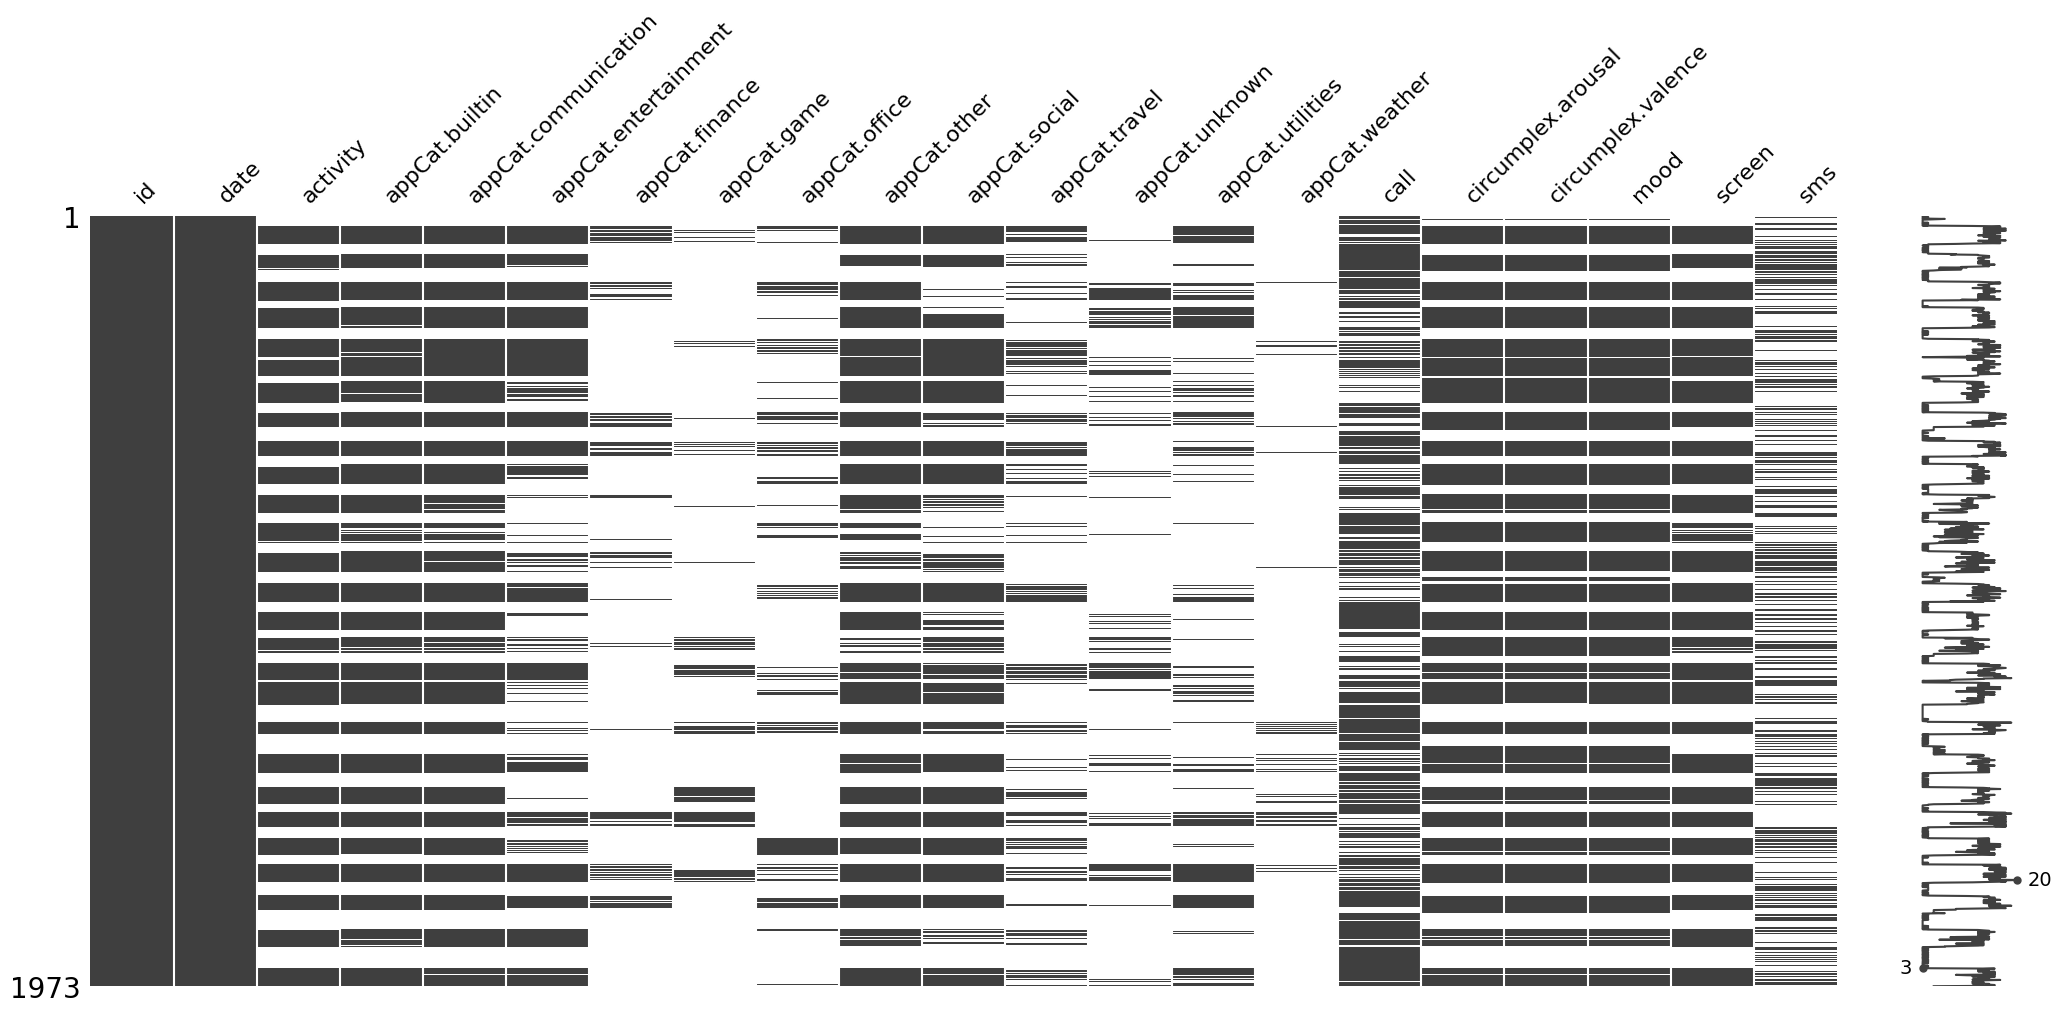

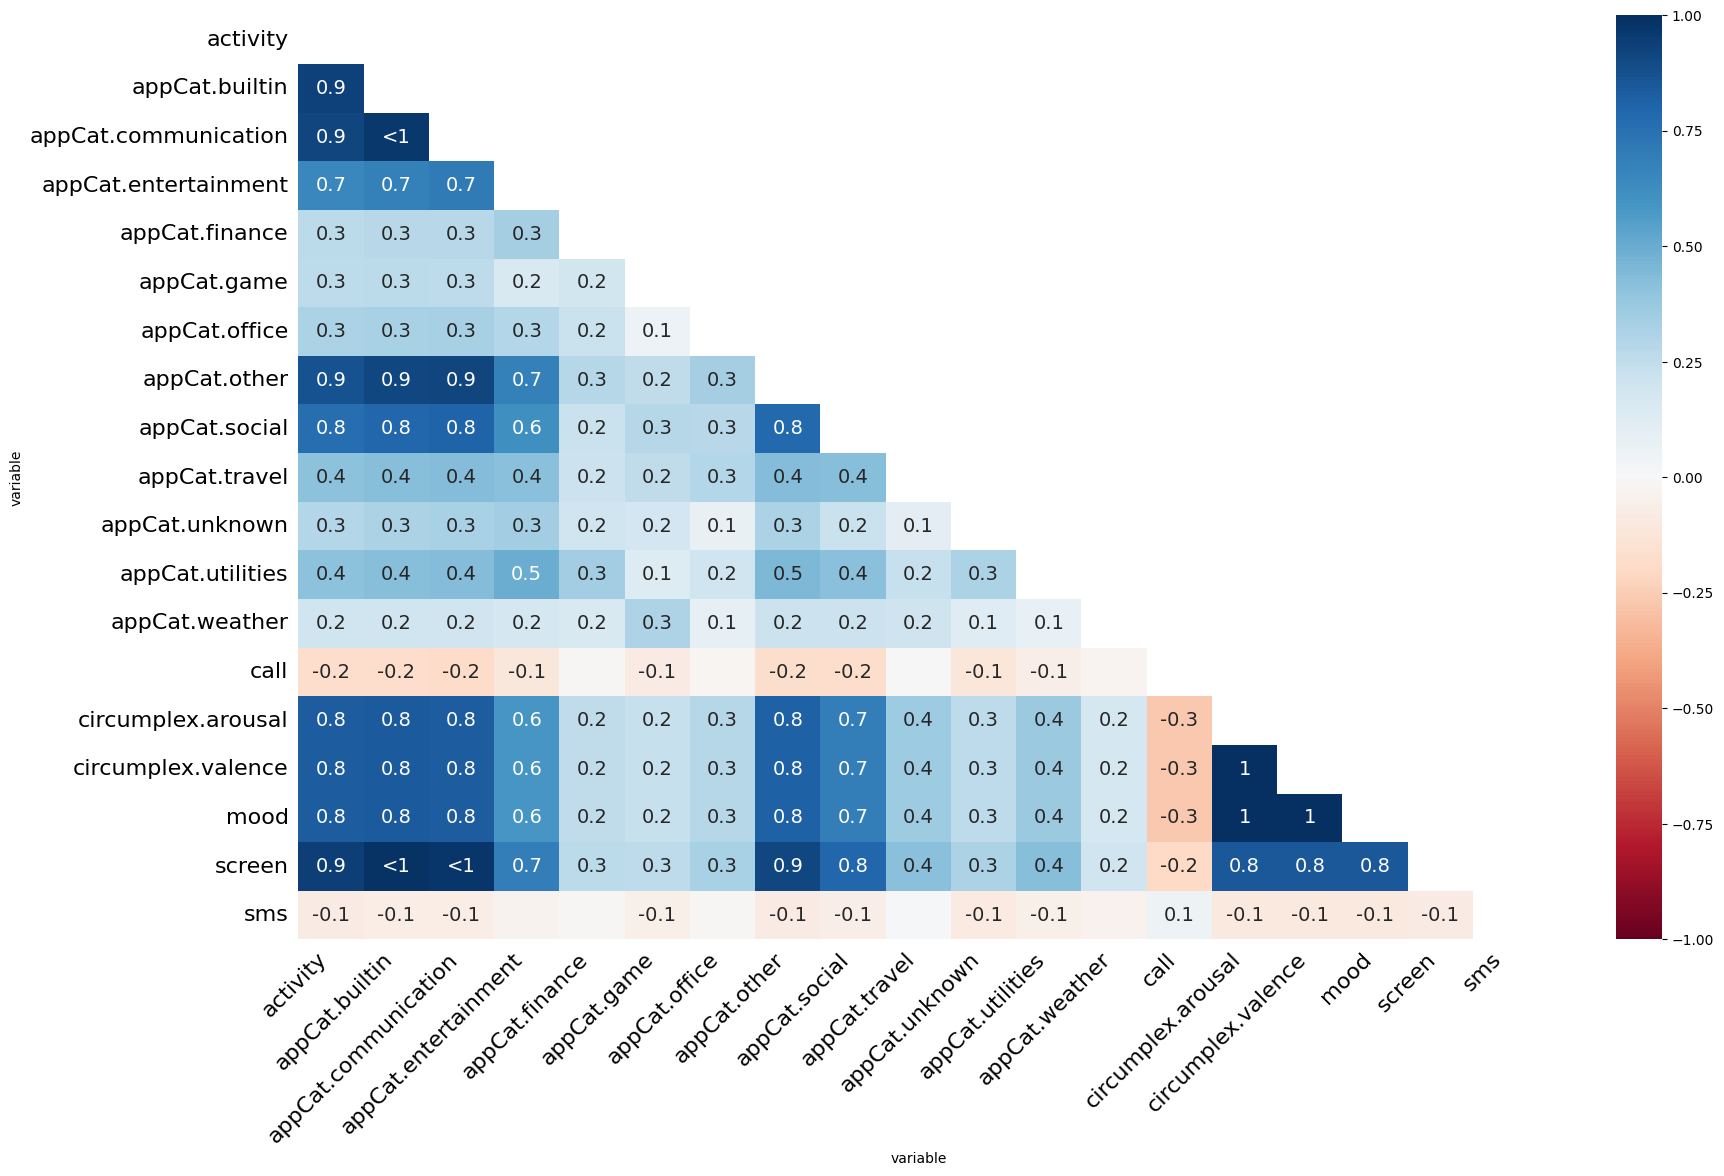

In [29]:
import missingno as msno

msno.bar(new_df)
plt.show()
msno.matrix(new_df)
plt.show()
msno.heatmap(new_df)
plt.show()

In [35]:
null_pattern = (np.random.random(41433).reshape((1973, 21)) > 0.5).astype(bool)
null_pattern = pd.DataFrame(null_pattern).replace({False: None})
msno.matrix(null_pattern.set_index(pd.period_range('17/2/2014', '9/6/2014', freq='D')) , freq='BQ')

ValueError: Length mismatch: Expected 1973 rows, received array of length 202

In [34]:
null_pattern

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,None,None,True,None,None,None,True,True,None,True,None,True,None,None,True,None,None,True,True,True
1,True,None,None,True,True,True,None,True,True,True,True,True,True,True,True,None,None,True,None,None
2,None,True,None,True,None,True,None,True,None,True,None,None,True,True,True,True,True,True,True,None
3,True,None,None,True,None,None,True,True,True,None,None,True,None,True,True,True,None,True,None,None
4,None,True,None,None,None,True,None,True,True,None,True,True,True,None,True,None,None,True,None,None
5,None,True,True,True,None,True,None,True,True,True,None,None,None,None,True,None,True,True,None,None
6,True,True,True,True,True,None,None,None,None,True,None,True,True,True,None,True,True,True,True,None
7,None,None,True,None,None,True,True,True,None,True,None,True,True,None,None,True,None,True,None,True
8,True,True,None,None,None,True,True,True,True,True,None,None,None,None,None,None,None,True,None,None
9,None,True,True,True,None,None,None,True,True,None,True,True,True,None,None,True,None,None,None,None
